# Explore Data

The simulator generates JPG images with dimensions 320x160x3, for 3 different camera positions labeled center, left and right, also time-stamped. The time stamp show that the average sample is around 10Hz. Below are a sample for this images.

### Define project specific python constants

In [1]:
SIMULATOR_DIR = "../simulator-linux/"
IMG_DIR       = SIMULATOR_DIR + "IMG/"
LABEL_CSV     = SIMULATOR_DIR + "driving_log.csv"
%pwd
%cd /home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3

/home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3


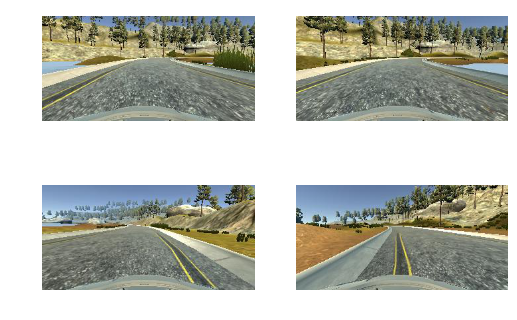

Done


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

center_imgs = glob(IMG_DIR+"center*")
center_arr = []
# Read only a sample of 10 images
for img in center_imgs[:4]:
    center_arr.append(mpimg.imread(img))

def plot_imgArr(img_arr):
    f, arr = plt.subplots(2,2)
    for n, subplt in enumerate(arr.reshape(-1)):
        subplt.imshow(img_arr[n])
        subplt.axis('off')

    plt.show()

plot_imgArr(center_arr)
print("Done")

In the images above we can se that some parts of it may not be of use for the network and may cause waste of time and memory resources. 
Then we can crop the upper part, and also part of the bottom where a part of the car is visible.

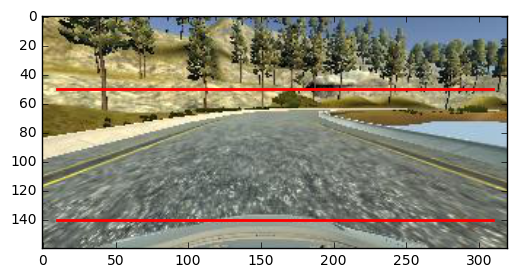

In [3]:
# select an image to visualize the region to crop
crop_img = plt.imread(center_imgs[1])
# Define the area of interest
BOTTOM_MARGIN = 50
TOP_MARGIN = 140
# Lines are defines as [x0, x1,...,xn], [y0, y1,...,yn]
plt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
plt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.imshow(crop_img);
# Draw the crop lines

In the image the red lines indicate the new limit of the image, then we will apply this reduction to all the center images.

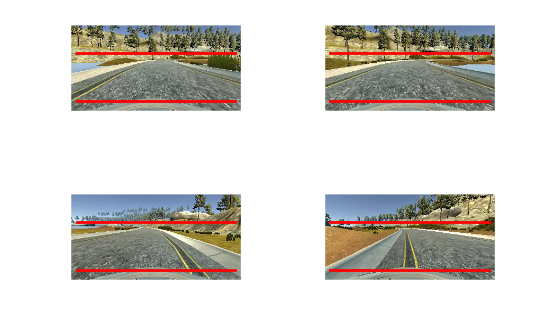

In [4]:
f, arr = plt.subplots(2,2)
for n, subplt in enumerate(arr.reshape(-1)):
    subplt.imshow(center_arr[n])
    subplt.axis('off')
    subplt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
    subplt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.show()

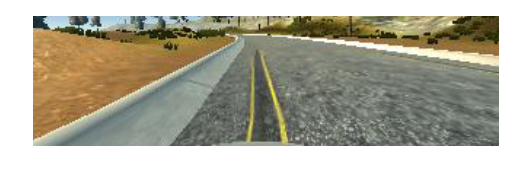

In [5]:
# apply the crop in all the images
img = plt.imread(center_imgs[3])
crop_img = img[50:140]
plt.axis('off')
plt.imshow(crop_img);

#### Learning Note:
As we can see in the image, the colors are it weird, this is because OpenCV reads the RGB colors in inverse order as maplotlib.
To solve this we need to, either use only OpenCV library or only Matplotlibs.

http://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/

# Analyze the generated CSV:

This is the content of the csv:
`center_img` | `left_img` | `rigth_img` | `steering_angle` | `throttle` | `Break` | `Speed`

In [7]:
import csv

labels_csv = csv.reader(open(LABEL_CSV, "r"))

steering_angles = []
center_imgs_path = []
left_imgs_path = []
rigth_imgs_path = []
data = {"center_path": center_imgs_path, "left_path":left_imgs_path, "rigth_path": rigth_imgs_path, "label":steering_angles}
for line in labels_csv:
    center_imgs_path.append(line[0])
    left_imgs_path.append(line[1])
    rigth_imgs_path.append(line[2])
    steering_angles.append(float(line[3]))

In the current project, our output is the steering angle. As we did in previous projects, we need to check if our data is well distributed, this way the model will be capable of better generalization in the future in comparison to skewed data.

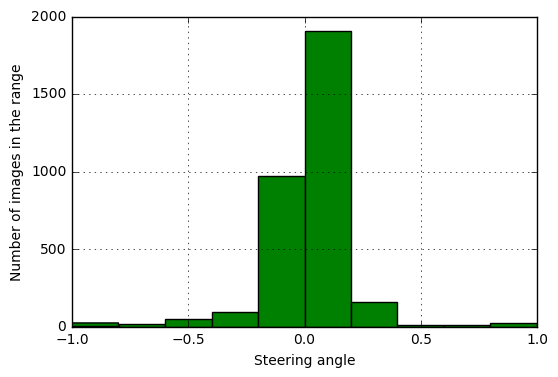

In [8]:
plt.hist(steering_angles, facecolor='green')
plt.xlabel('Steering angle')
plt.ylabel('Number of images in the range')
plt.grid(True)
plt.show()

As described int the image is clear that our data is skewed by straigth driving samples. Then it's neccesary to balance the data, this will be done by getting more data
and also with data augmentation.

In [9]:
# create list for data
X = []
# create list for labels
y = []

for label, data in zip(steering_angles, center_imgs_path):
    # crop data to our defined area of interest
    X.append(plt.imread(data)[BOTTOM_MARGIN:TOP_MARGIN])
    y.append(label)


print(len(X))
print(len(y))

3250
3250


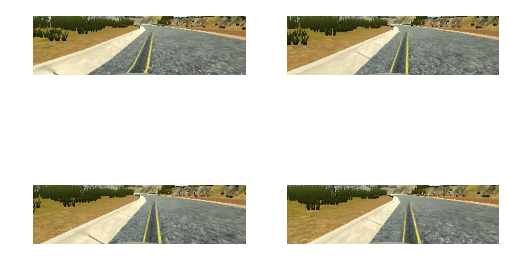

In [10]:
plot_imgArr(X[100:104]) ## Print olny 4 images

Convert to float and add dimension for the labels. 
Also normalize the RGB values. 

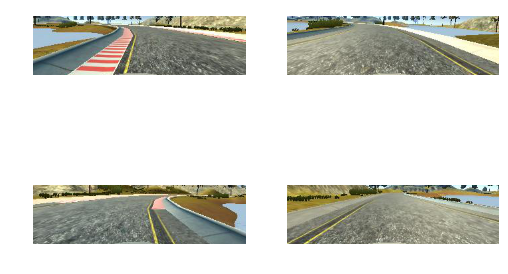

(3250, 90, 320, 3)
(3250, 1)


In [14]:
import cv2
X = np.asarray(X).astype('float32')
X_norm = []
for img in X:
    norm_image = cv2.normalize(img, dst=img.copy(), alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_norm.append(norm_image)

plot_imgArr(X_norm[100:104])
X = np.asarray(X_norm)
y = np.asarray(y).astype('float32')
y = y.reshape((y.shape[0],1))
print(X.shape)
print(y.shape)

From the images we can see that the normalization clears the image.

Now using sklearn tools shuffle and get the validation data.

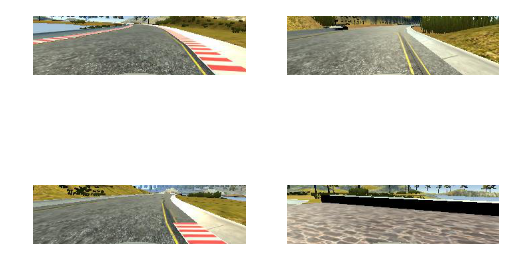

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X,y = shuffle(X,y)
plot_imgArr(X[100:104])

In [29]:
X, X_val, y, y_val = train_test_split(X, y, random_state=0, test_size=0.2)

## Naive implementation:

In this implementation I want to measure the influence of the preprocessing in the behaviour of the network.
For this Keras will be fetching the data I have stored of 4 laps in the simulator.

In [27]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

# Current shape: 90x320x3

# Instantiate a Sequential model
model = Sequential()
# Add first convolution layer

# 

model.add(Convolution2D(1,1,1, border_mode='same', input_shape=(X.shape[1],X.shape[2],X.shape[3]), dim_ordering='tf'))
# shape ()
model.add(Convolution2D(14, 10, 10, border_mode='valid', activation='relu'))
model.add(MaxPooling2D((4,4),(4,4),'valid'))
model.add(Dropout(0.75))

model.add(Convolution2D(28, 7, 7, border_mode='valid', activation='relu'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='relu'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_22 (Convolution2D) (None, 90, 320, 1)    4           convolution2d_input_10[0][0]     
____________________________________________________________________________________________________
convolution2d_23 (Convolution2D) (None, 81, 311, 14)   1414        convolution2d_22[0][0]           
____________________________________________________________________________________________________
maxpooling2d_12 (MaxPooling2D)   (None, 20, 77, 14)    0           convolution2d_23[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 20, 77, 14)    0           maxpooling2d_12[0][0]            
___________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
adam_opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
model.compile(loss='mean_squared_error',optimizer=adam_opt)
log = model.fit(X, y,batch_size=40, nb_epoch=5, verbose=1, validation_data=(X_val, y_val))

Train on 2600 samples, validate on 650 samples
Epoch 1/5
2600/2600 [==============================] - 123s - loss: 0.0318 - val_loss: 0.0280
Epoch 2/5
2600/2600 [==============================] - 124s - loss: 0.0318 - val_loss: 0.0280
Epoch 3/5
2600/2600 [==============================] - 123s - loss: 0.0318 - val_loss: 0.0280
Epoch 4/5
2560/2600 [============================>.] - ETA: 1s - loss: 0.0322

Save the Model and Data

In [31]:
open("model.json", "w").write(model.to_json())
model.save_weights("model.h5")

Plot some images and the predicted steering angle for a quick comparison.

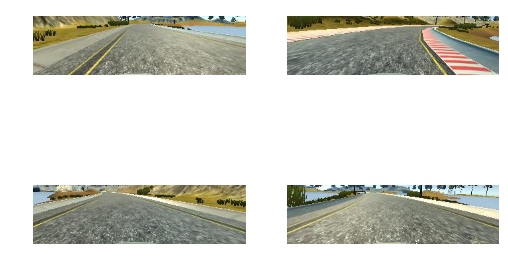

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [36]:
pred = model.predict(X[31:35])
plot_imgArr(X[31:35])
print(pred)